### Import dependencise

In [40]:
# Common
import os 
import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data 
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import albumentations as A      # data augmentation library

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [12]:
np.random.seed(2024)
SIZE = 256      # (heigth x width)

In [4]:
classes_colors = pd.read_csv("CamVid\\class_dict.csv")
classes_colors = classes_colors.T
classes_colors

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


### Functions

In [347]:
def show_pairs(images, masks, cmap=None):
    if images.shape[0] != masks.shape[0]:
        raise ValueError("Number of images must be equal to the number of masks.")
    
    if len(images.shape) == 3:      # means that it's a single pair of images to be plotted
        plt.subplot(1,2,1)
        plt.imshow(images)
        plt.subplot(1,2,2)
        plt.imshow(masks)
    
    else:
        n = images.shape[0]
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(8,3*n))
        for i in range(n):
            axs[i, 0].imshow(images[i])
            axs[i, 1].imshow(masks[i], cmap=cmap)
        plt.tight_layout()


def load_image(path, SIZE):
    img = load_img(path)
    img = img_to_array(img)
    img = tfi.resize(img, (SIZE, SIZE))
    img = tf.cast(img, tf.float32)      # convert data type to float
    img = img/255.                      # normalize to [0,1]
    return img

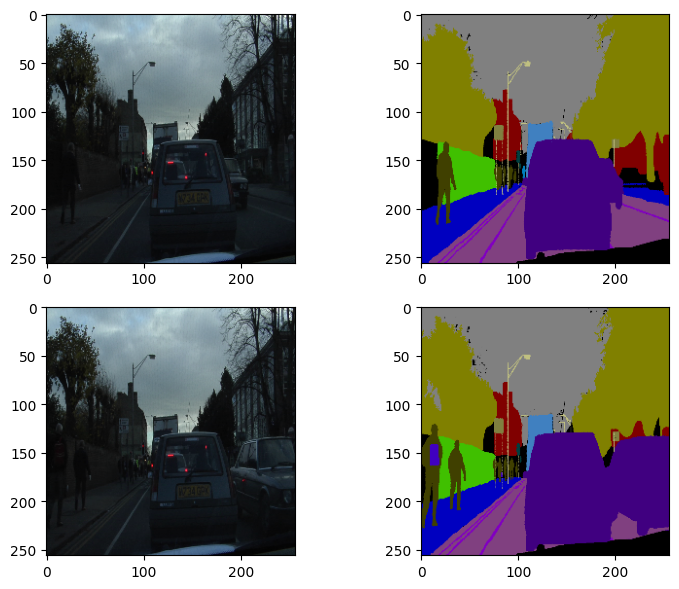

In [345]:
show_pairs(train_images[:2], train_masks[:2])

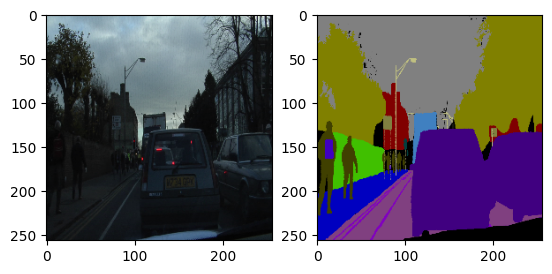

In [348]:
show_pairs(train_images[1], train_masks[1])

### Data Loading

Use sorted(glob()) syntax to visualize in an array the images in the same order that we obtain by opening manually our data folders.

In [6]:
root_path = 'CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [7]:
len(train_image_paths), len(val_image_paths), len(test_image_paths)

(369, 100, 232)

In [8]:
len(train_mask_paths), len(val_mask_paths), len(test_mask_paths)

(369, 100, 232)

In [9]:
# creating null vectors to store the pixel values for each image in an array
train_images = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))
train_masks = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))

val_images = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))
val_masks = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))

test_images = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))
test_masks = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))

for i,path in tqdm(enumerate(train_image_paths), desc="Train Images"):
    image = load_image(path, SIZE=SIZE)
    train_images[i] = image

for i,path in tqdm(enumerate(train_mask_paths), desc="Train Masks"):
    image = load_image(path, SIZE=SIZE)
    train_masks[i] = image
    
for i,path in tqdm(enumerate(val_image_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_images[i] = image
    
for i,path in tqdm(enumerate(val_mask_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_masks[i] = image

for i,path in tqdm(enumerate(test_image_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_images[i] = image
    
for i,path in tqdm(enumerate(test_mask_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_masks[i] = image

Train Images: 7it [00:00, 16.79it/s]

Train Images: 369it [00:18, 19.50it/s]
Train Masks: 369it [00:18, 20.48it/s]
Valid Masks: 100it [00:04, 21.80it/s]
Valid Masks: 100it [00:03, 30.71it/s]
Test Masks: 232it [00:09, 23.93it/s]
Test Masks: 232it [00:06, 33.82it/s]


In [16]:
train_images.shape

(369, 256, 256, 3)

Now we have 6 tensors full of pixel information of resized, float type and normalized images.

Let's visualize what we are dealing with.

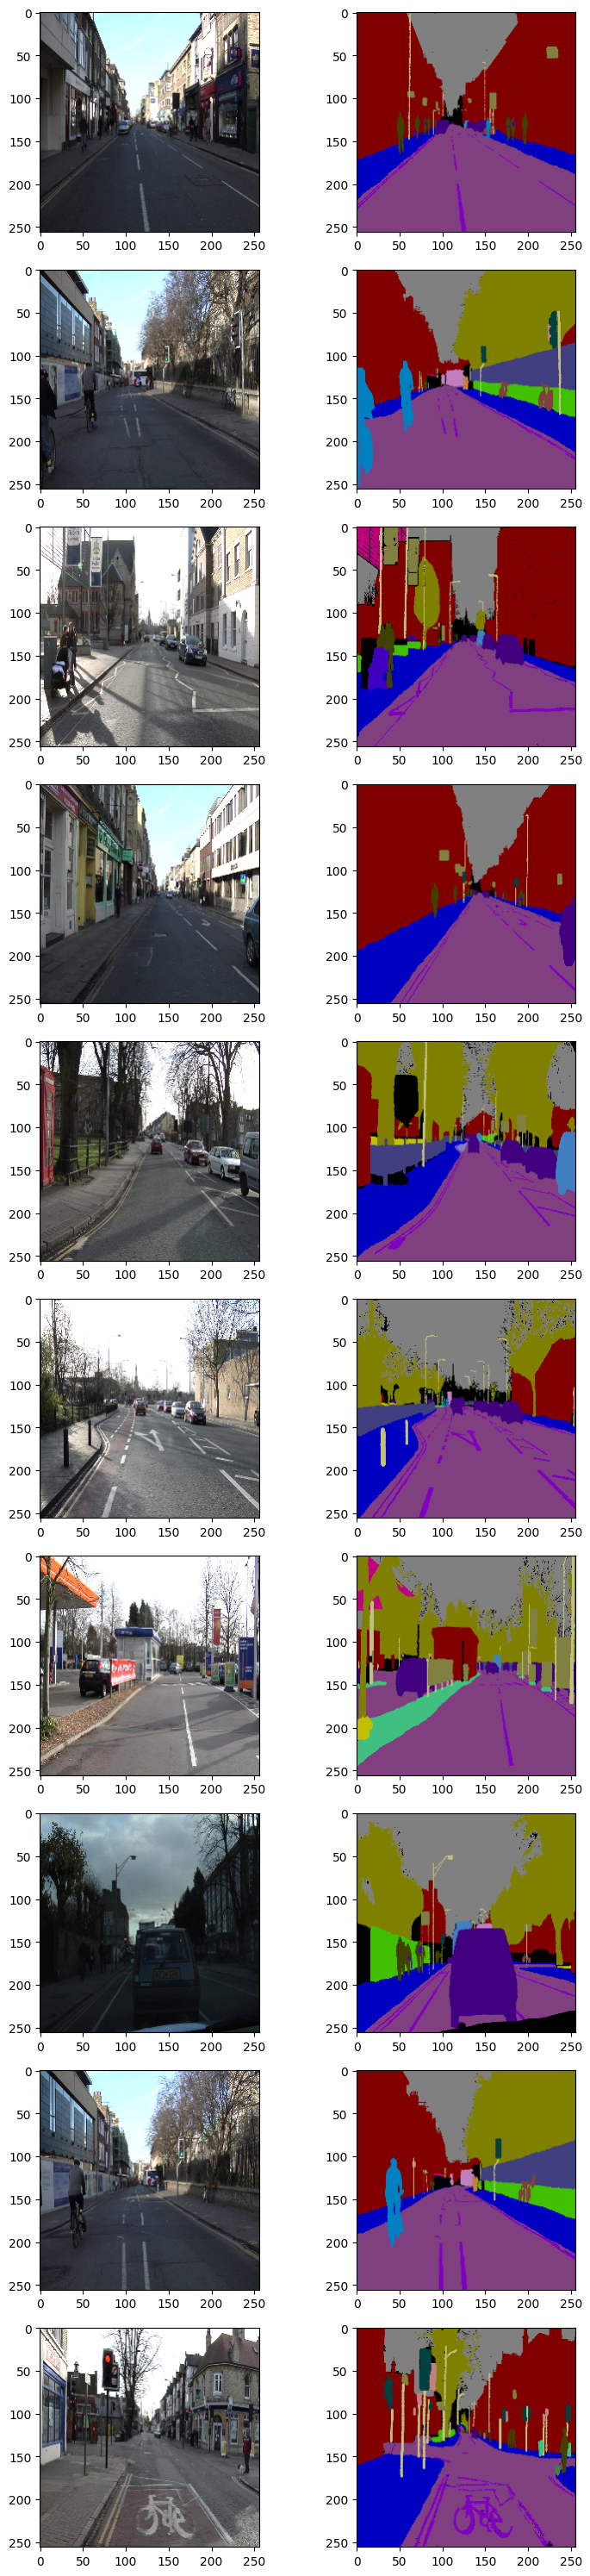

In [340]:
idx = np.random.randint(train_images.shape[0], size=10)
show_pairs(train_images[idx], train_masks[idx])

### Data Augmentation

- Horizontal Flip (HorizontalFlip):
Flips the image horizontally with a certain probability.
Purpose: Helps the model become invariant to horizontal flipping, which is often a valid transformation in images.

- Vertical Flip (VerticalFlip):
Flips the image vertically with a certain probability.
Purpose: Similar to horizontal flip, it helps the model become invariant to vertical flipping.

- Random Rotation (Rotate):
Rotates the image by a random angle within a specified range.
Purpose: Increases robustness by exposing the model to various orientations of objects in the scene.

- Random Brightness/Contrast (RandomBrightnessContrast):
Adjusts the brightness and contrast of the image randomly.
Purpose: Helps the model generalize well to different lighting conditions.

- Elastic Transform (ElasticTransform):
Applies elastic deformation to the image, simulating local deformations.
Purpose: Enhances the model's ability to handle deformations and variations in object shapes.

- Grid Distortion (GridDistortion):
Distorts the image by moving grid points around.
Purpose: Introduces local distortions that can improve the model's robustness to spatial variations.

- Optical Distortion (OpticalDistortion):
Simulates optical distortion in the image by applying random geometric transformations.
Purpose: Mimics distortions that might occur in real-world scenarios, helping the model generalize better.

- Resize (Resize):
Resizes the image and corresponding masks to a specified size.
Purpose: Ensures consistency in input sizes and is often used to handle images of different resolutions.

- Compose (Compose):
Composes multiple augmentations into a sequential pipeline.
Purpose: Allows you to apply a series of augmentations to the input data in a specific order. The Compose function takes a list of augmentation functions, and you can control the probability of each augmentation.

- Rotate (Rotate):
Rotates the input by a random angle within a specified range.
Purpose: Enhances the model's robustness by exposing it to different orientations of objects in the scene.

In [ ]:

from albumentations import (
    Compose,
    HorizontalFlip,
    VerticalFlip,
    Rotate,
    RandomBrightnessContrast,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    Resize,
)

# Define augmentation pipeline
augmentation = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    RandomBrightnessContrast(p=0.2),
    ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    GridDistortion(p=0.2),
    OpticalDistortion(p=0.3, distort_limit=2, shift_limit=0.5),
])


In [256]:
aug = A.HorizontalFlip(p=1)
augmented = aug(image = train_images[0], mask = train_masks[0])

In [257]:
augmented.keys()

dict_keys(['image', 'mask'])

In [273]:
img_flipped = augmented['image']
mask_flipped = augmented['mask']

In [287]:
show_pairs(train_masks[0],train_images[0])

Error in callback <function _draw_all_if_interactive at 0x0000025D047A49D0> (for post_execute):


ValueError: Image size of 800x76800 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 800x76800 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x76800 with 512 Axes>

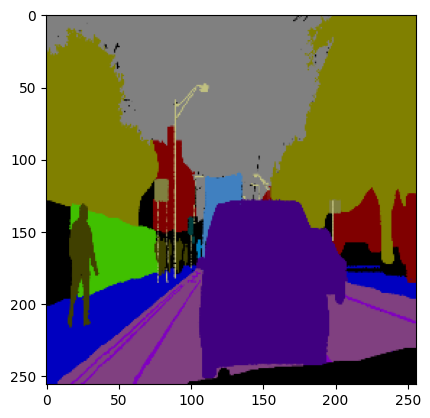

In [284]:
plt.imshow(train_masks[0])

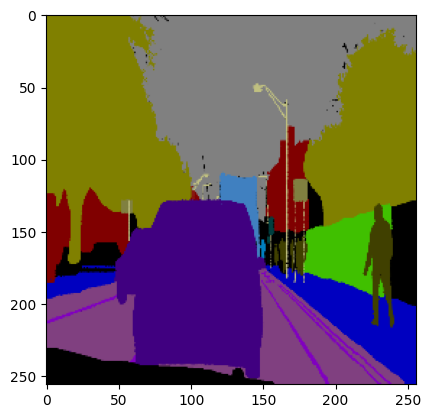

In [283]:
plt.imshow(mask_flipped)

In [276]:
img_flipped.shape

(256, 256, 3)